In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [4]:
DATA_DIR = 'C:/Users/salvarc/data/oisstv2'
YEAR = 2019
ds = xr.open_dataset(DATA_DIR + f'/sst.day.mean.{YEAR}.nc', decode_times=True, use_cftime=True)

# Plot squared grids

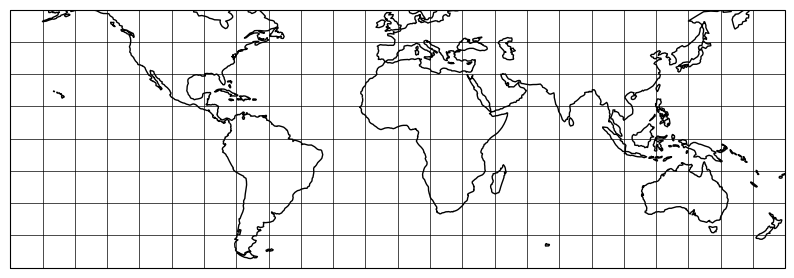

In [5]:
# Now, let's discretize the grid into multiple 60x60 boxes
# First let's get the latitudes and longitudes of the grid
lats = ds.lat.values
lons = ds.lon.values
# Now, let's get the limits of each box
spacing = 60
lat_limits = lats[::spacing]
lon_limits = lons[::spacing]
# Now, let's plot the resulting boxes
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': projection})
ax.coastlines()
# don't plot polar regions
miny, maxy = -60, 60
ax.set_extent([-180, 180, miny, maxy], crs=projection)
lat_limits = [l for l in lat_limits if miny <= l <= maxy]
# Plot horizontal lines
for lat in lat_limits:
    ax.plot([lons[0], lons[-1]], [lat, lat], color='k', transform=projection, linewidth=0.5)
# Plot vertical lines
for lon in lon_limits:
    ax.plot([lon, lon], [lats[0], lats[-1]], color='k', transform=projection, linewidth=0.5)
# print the lats lons of the pure ocean Pacific region grid boxes
# print(lat_limits[:6])
# print(lon_limits[:6] + 180)  # add 180 to get the correct longitude, since the first longitude goes through the middle of the plot below

## Plot the boxes with more than 95% ocean coverage

C:\Users\salvarc\Anaconda3\envs\convex-diffusion\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\salvarc\Anaconda3\envs\convex-diffusion\lib\site-packages\cartopy\crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\salvarc\Anaconda3\envs\convex-diffusion\lib\site-packages\cartopy\crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)

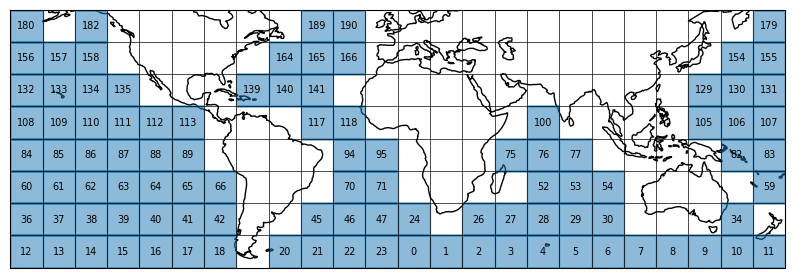

In [8]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': projection})
ax.coastlines()
# don't plot polar regions
miny, maxy = -60, 60
ax.set_extent([-180, 180, miny, maxy], crs=projection)
lat_limits = [l for l in lat_limits if miny <= l <= maxy]
# Plot horizontal lines
for lat in lat_limits:
    ax.plot([lons[0], lons[-1]], [lat, lat], color='k', transform=projection, linewidth=0.5)
# Plot vertical lines
for lon in lon_limits:
    ax.plot([lon, lon], [lats[0], lats[-1]], color='k', transform=projection, linewidth=0.5)
# Plot the boxes that have at least 90% ocean, and
#  create a new index that assigns each pixel to a box:
sst_t0 = ds.sst.isel(time=0)
box_index_to_lat_lon = {}
for lat_index, lat_min in enumerate(lat_limits):
    for lon_index, lon_min in enumerate(lon_limits):
        grid_box_index = lat_index * len(lon_limits) + lon_index
        # Get the next lat and lon limits (exclusive, so substract a small number, here 0.001)
        lat_max = lat_limits[lat_index + 1] - 0.001 if lat_index < len(lat_limits) - 1 else maxy
        lon_max = lon_limits[lon_index + 1] - 0.001 if lon_index < len(lon_limits) - 1 else 360
        # save the lat lon limits of the box (for later)
        box_index_to_lat_lon[grid_box_index] = (lat_min, lat_max, lon_min, lon_max)
        # select the grid box
        sst_box = sst_t0.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
        assert sst_box.lat.size == spacing and sst_box.lon.size == spacing, f'{grid_box_index}: Box size is {sst_box.lat.size}x{sst_box.lon.size}'
        # compute the fraction of ocean in the box
        ocean_fraction = sst_box.notnull().sum(dim=('lat', 'lon')) / spacing**2
        if ocean_fraction > 0.95:
            # fill the box with a color
            ax.fill_between([lon_min, lon_max], [lat_min, lat_min], [lat_max, lat_max], color='C0', transform=projection, alpha=0.5)
            # else:
            # put the box number in the box
            center_lat, center_lon = (lat_min + lat_max) / 2, (lon_min + lon_max) / 2
            ax.text(center_lon, center_lat, f'{grid_box_index}', transform=projection, ha='center', va='center', color='k', fontsize=7)